# Loading data via wikipedia API

In [1]:
%cd C:\Users\piecz\PycharmProjects\pythonProject2\WdAN_projekt

C:\Users\piecz\PycharmProjects\pythonProject2\WdAN_projekt


In [ ]:
!pip install wikipedia-api

In [2]:
import pandas as pd
import numpy as np
import wikipediaapi
import functions.wikipedia_use as my_wiki
import sqlite3
import os
import requests
from datetime import datetime, timedelta
from IPython.display import display

### Preparing list of ~5000-10 000 articles from chosen categories:
- Logic puzzles

In [42]:
import wikipediaapi
import time
import random


def get_articles_from_category(category_name, lang="en", depth=0):
    wiki = wikipediaapi.Wikipedia(
        language=lang,
        user_agent="StudentProject/1.0 (estera.maria03@gmail.com)"
    )

    category = wiki.page(category_name)
    pages = {}
    

    def add_articles(cat, current_depth=0):
        print(len(cat.categorymembers.values()))
        for page in cat.categorymembers.values():
            if page.ns == 0:
                pages[page.title] = page.fullurl
                delay = random.uniform(0, 1) 
                time.sleep(delay)
            elif page.ns == 14 and current_depth < depth:
                add_articles(page, current_depth + 1)

    add_articles(category)
    return pages

def get_pageviews(article, lang="en", days_back=30):
    """Return total pageviews over the last N days."""
    end = datetime.today()
    start = end - timedelta(days=days_back)
    url = (
        f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/"
        f"{lang}.wikipedia/all-access/user/{article.replace(' ', '_')}/daily/"
        f"{start.strftime('%Y%m%d')}/{end.strftime('%Y%m%d')}"
    )
    headers = {"User-Agent": "StudentProject/1.0 (estera.maria03@gmail.com)"}
    r = requests.get(url, headers=headers)
    if r.status_code != 200:
        return None
    data = r.json()
    views = sum(item["views"] for item in data["items"])
    return views

def get_clicks(article, month="2024-09", lang="en"):
    """Return incoming and outgoing click counts for a Wikipedia article."""
    url = f"https://dumps.wikimedia.org/other/clickstream/{month}/clickstream-{lang}wiki-{month}.tsv.gz"
    cols = ["prev", "curr", "type", "n"]
    df = pd.read_csv(url, sep="\t", names=cols)

    article_clean = article.replace(" ", "_")
    clicks_out = df.loc[(df["prev"] == article_clean) & (df["type"] == "link"), "n"].sum()
    clicks_in = df.loc[(df["curr"] == article_clean) & (df["type"] == "link"), "n"].sum()
    return clicks_in, clicks_out

import wikipediaapi

def get_num_images(title, lang="en"):
    """Return number of images in a Wikipedia article."""
    url = f"https://{lang}.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "titles": title,
        "prop": "images",
        "format": "json",
        "imlimit": "max"
    }
    headers = {"User-Agent": "StudentProject/1.0 (estera.maria03@gmail.com)"}
    r = requests.get(url, params=params, headers=headers)
    data = r.json()
    pages = data.get("query", {}).get("pages", {})
    page = next(iter(pages.values()))
    imgs = page.get("images", [])
    return len(imgs)



def get_article_metadata(title, lang="en"):
    """Fetch extended metadata for a Wikipedia article."""
    wiki = wikipediaapi.Wikipedia(
        language=lang,
        user_agent="StudentProject/1.0 (estera.maria03@gmail.com)"
    )
    page = wiki.page(title)
    if not page.exists():
        return None

    num_words = len(page.text.split())
    num_links_internal = len(page.links)
    num_categories = len(page.categories)
    num_images = num_images = get_num_images(title)
    summary = page.summary.strip()
    
    return {
        "num_words": num_words,
        "num_links_internal": num_links_internal,
        "num_categories": num_categories,
        "num_images": num_images,
        "summary": summary
    }


In [16]:
articles = get_articles_from_category("Category:Logic puzzles", lang="en", depth=1)

print(f"Found {len(articles)} articles:")
for i, (title, url) in enumerate(articles.items()):
    print(f"{i+1}. {title} → {url}")


92
32
17
43
3
21
Found 185 articles:
1. Logic puzzle → https://en.wikipedia.org/wiki/Logic_puzzle
2. Ages of Three Children puzzle → https://en.wikipedia.org/wiki/Ages_of_Three_Children_puzzle
3. Bag (puzzle) → https://en.wikipedia.org/wiki/Bag_(puzzle)
4. Balance puzzle → https://en.wikipedia.org/wiki/Balance_puzzle
5. Battleship (puzzle) → https://en.wikipedia.org/wiki/Battleship_(puzzle)
6. Bridge and torch problem → https://en.wikipedia.org/wiki/Bridge_and_torch_problem
7. Bulls and cows → https://en.wikipedia.org/wiki/Bulls_and_cows
8. Cheryl's Birthday → https://en.wikipedia.org/wiki/Cheryl%27s_Birthday
9. Coercive logic → https://en.wikipedia.org/wiki/Coercive_logic
10. Cross-figure → https://en.wikipedia.org/wiki/Cross-figure
11. Dissection puzzle → https://en.wikipedia.org/wiki/Dissection_puzzle
12. Escape room → https://en.wikipedia.org/wiki/Escape_room
13. Fill-In (puzzle) → https://en.wikipedia.org/wiki/Fill-In_(puzzle)
14. Fillomino → https://en.wikipedia.org/wiki/Fillomin

### Loading data and saving to the database

In [ ]:
wiki = wikipediaapi.Wikipedia(
    language="en",
    user_agent="StudentProject/1.0 (estera.maria03@gmail.com)"
)

In [24]:
## creation of database if doesn't exist

db_path = os.path.abspath("data/wikipedia_data.db")
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS articles (
    title TEXT PRIMARY KEY,
    url TEXT,
    num_words INTEGER,
    summary TEXT
)
""")
conn.commit()

In [38]:
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS articles (
        title TEXT PRIMARY KEY,
        url TEXT,
        num_words INTEGER,
        summary TEXT
    )
    """)

    # --- pętla po artykułach ---
    for i, (title, url) in enumerate(articles.items(), 1):
        try:
            page = wiki.page(title)
            text = page.text
            summary = page.summary.strip()
            num_words = len(text.split())

            cursor.execute("""
            INSERT OR REPLACE INTO articles (title, url, num_words, summary)
            VALUES (?, ?, ?, ?)
            """, (title, url, num_words, summary))

            conn.commit()
            print(f"[{i}/{len(articles)}] Saved: {title} ({num_words} words)")

            time.sleep(random.uniform(0, 1))

        except Exception as e:
            print(f"[{i}] Failed: {title} ({e})")

print(f"\n✅ Done! Database saved at: {db_path}")

[1/185] Saved: Logic puzzle (503 words)
[2/185] Saved: Ages of Three Children puzzle (516 words)
[3/185] Saved: Bag (puzzle) (321 words)
[4/185] Saved: Balance puzzle (3978 words)


KeyboardInterrupt: 

In [39]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

title = "Rubik's Cube"

cursor.execute("SELECT * FROM articles WHERE title = ?", (title,))
row = cursor.fetchone()

if row:
    print(f"Title: {row[0]}")
    print(f"URL: {row[1]}")
    print(f"Words: {row[2]}")
    print(f"Summary:\n{row[3]}")
else:
    print("Not found.")

conn.close()

Title: Rubik's Cube
URL: https://en.wikipedia.org/wiki/Rubik%27s_Cube
Words: 7799
Summary:
The Rubik's Cube is a 3D combination puzzle invented in 1974 by Hungarian sculptor and professor of architecture Ernő Rubik. Originally called the Magic Cube, the puzzle was licensed by Rubik to be sold by Pentangle Puzzles in the UK in 1978, and then by Ideal Toy Corp in 1980 via businessman Tibor Laczi and Seven Towns founder Tom Kremer. The cube was released internationally in 1980 and became one of the most recognized icons in popular culture. It won the 1980 German Game of the Year special award for Best Puzzle. As of January 2024, around 500 million cubes had been sold worldwide, making it the world's bestselling puzzle game and bestselling toy. The Rubik's Cube was inducted into the US National Toy Hall of Fame in 2014.
On the original, classic Rubik's Cube, each of the six faces was covered by nine stickers, with each face in one of six solid colours: white, red, blue, orange, green, and 

##### Extended version

In [38]:
import wikipediaapi
import requests
import pandas as pd
import sqlite3
import os
import time
import random
from datetime import datetime, timedelta

# ============================================================
# 1️⃣  KONFIGURACJA
# ============================================================

LANG = "en"
CATEGORY = "Category:Logic puzzles"
CLICKSTREAM_PATH = "C:\\Users\\piecz\\PycharmProjects\\pythonProject2\\WdAN_projekt\\data\\clickstream-enwiki-2024-09.tsv.gz"
USER_AGENT = "StudentProject/1.0 (estera.maria03@gmail.com)"

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)
DB_PATH = os.path.join(DATA_DIR, "wikipedia_ctr.db")

# ============================================================
# 2️⃣  FUNKCJE POMOCNICZE
# ============================================================

def get_articles_from_category(category_name, lang="en", depth=0):
    """Fetch articles from a Wikipedia category (non-recursive by default)."""
    wiki = wikipediaapi.Wikipedia(language=lang, user_agent=USER_AGENT)
    category = wiki.page(category_name)
    pages = {}
    def add_articles(cat, current_depth=0):
        for page in cat.categorymembers.values():
            if page.ns == 0:
                pages[page.title] = page.fullurl
            elif page.ns == 14 and current_depth < depth:
                add_articles(page, current_depth + 1)
    add_articles(category)
    return pages


def get_article_metadata(title, lang="en"):
    """Fetch metadata for a Wikipedia article (text, links, categories, summary)."""
    wiki = wikipediaapi.Wikipedia(language=lang, user_agent=USER_AGENT)
    page = wiki.page(title)
    if not page.exists():
        return None
    num_words = len(page.text.split())
    num_links_internal = len(page.links)
    num_categories = len(page.categories)
    summary = page.summary.strip()
    return {
        "num_words": num_words,
        "num_links_internal": num_links_internal,
        "num_categories": num_categories,
        "summary": summary
    }


def get_pageviews(article, lang="en", days_back=30):
    """Return total pageviews in last N days."""
    end = datetime.today()
    start = end - timedelta(days=days_back)
    url = (
        f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/"
        f"{lang}.wikipedia/all-access/user/{article.replace(' ', '_')}/daily/"
        f"{start.strftime('%Y%m%d')}/{end.strftime('%Y%m%d')}"
    )
    headers = {"User-Agent": USER_AGENT}
    r = requests.get(url, headers=headers)
    if r.status_code != 200:
        return None
    data = r.json()
    return sum(item["views"] for item in data["items"])


def get_clicks_from_local(article, path=CLICKSTREAM_PATH):
    """Compute incoming and outgoing click counts for a specific article from a local Clickstream file."""
    article_clean = article.replace(" ", "_")
    cols = ["prev", "curr", "type", "n"]
    chunksize = 1_000_000

    clicks_in, clicks_out = 0, 0
    for chunk in pd.read_csv(path, sep="\t", names=cols, chunksize=chunksize):
        mask_link = chunk["type"] == "link"
        mask_in = mask_link & (chunk["curr"] == article_clean)
        mask_out = mask_link & (chunk["prev"] == article_clean)
        clicks_in += chunk.loc[mask_in, "n"].sum()
        clicks_out += chunk.loc[mask_out, "n"].sum()

    return int(clicks_in), int(clicks_out)


# ============================================================
# 3️⃣  TWORZENIE BAZY DANYCH
# ============================================================

with sqlite3.connect(DB_PATH) as conn:
    cursor = conn.cursor()
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS articles2  (
        title TEXT PRIMARY KEY,
        url TEXT,
        num_words INTEGER,
        num_links_internal INTEGER,
        num_categories INTEGER,
        views_last_30d INTEGER,
        clicks_in INTEGER,
        clicks_out INTEGER,
        ctr REAL,
        summary TEXT
    )
    """)
    conn.commit()

In [3]:

# ============================================================
# 4️⃣  POBIERANIE DANYCH
# ============================================================

articles = get_articles_from_category(CATEGORY, lang=LANG, depth=1)
print(f"📚 Found {len(articles)} articles in {CATEGORY}")

📚 Found 185 articles in Category:Logic puzzles


In [39]:

# ============================================================
# 5️⃣  PRZETWARZANIE I ZAPIS DO BAZY
# ============================================================

with sqlite3.connect(DB_PATH) as conn:
    cursor = conn.cursor()

    for i, (title, url) in enumerate(articles.items(), 1):
        try:
            meta = get_article_metadata(title)
            print("meta")
            if not meta:
                print(f"[{i}] Skipped (no page): {title}")
                continue

            views = get_pageviews(title) or 0
            print("views")
            clicks_in, clicks_out = get_clicks_from_local(title)
            print("clicks")
            ctr = (clicks_out / views) if (views > 0) else None

            cursor.execute("""
            INSERT OR REPLACE INTO articles
            (title, url, num_words, num_links_internal, num_categories,
             views_last_30d, clicks_in, clicks_out, ctr, summary)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (
                title, url,
                meta["num_words"],
                meta["num_links_internal"],
                meta["num_categories"],
                views,
                clicks_in,
                clicks_out,
                ctr,
                meta["summary"]
            ))

            conn.commit()
            print(f"[{i}/{len(articles)}] ✅ {title} (views={views}, CTR={ctr})")
            time.sleep(random.uniform(0, 0.2))  

        except Exception as e:
            print(f"[{i}] ❌ Failed {title}: {e}")

print(f"\n✅ Done! Database saved at: {DB_PATH}")


meta
views


KeyboardInterrupt: 

In [21]:
DB_PATH = "data/wikipedia_ctr.db"

with sqlite3.connect(DB_PATH) as conn:
    df = pd.read_sql_query("SELECT * FROM articles;", conn)

display(df.head())


,title,url,num_words,num_links_internal,num_categories,views_last_30d,clicks_in,clicks_out,ctr,summary
0,Logic puzzle,https://en.wikipedia.org/wiki/Logic_puzzle,503,66,8,3184,864,887,0.278580,A logic puzzle is a puzzle deriving from the m...
1,Ages of Three Children puzzle,https://en.wikipedia.org/wiki/Ages_of_Three_Ch...,516,10,3,736,0,0,0.000000,The Ages of Three Children puzzle (sometimes r...
2,Bag (puzzle),https://en.wikipedia.org/wiki/Bag_(puzzle),321,15,10,307,120,11,0.035831,Bag (also called Corral or Cave) is a binary-d...
3,Balance puzzle,https://en.wikipedia.org/wiki/Balance_puzzle,3978,14,3,2921,98,28,0.009586,A balance puzzle or weighing puzzle is a logic...
4,Battleship (puzzle),https://en.wikipedia.org/wiki/Battleship_(puzzle),733,15,6,771,415,99,0.128405,The Battleship puzzle (sometimes called Bimaru...


In [28]:
keywords = ["logic","puzzle","rubik","problem"," math", " cube ","game"]

for k in keywords:
    df[k] =( (df.title.str.lower().str.contains(k) )| (df.summary.str.lower().str.contains(k))) 
display(df.sample(6))

df['links_per_word'] = df.num_links_internal/df.num_words

,title,url,num_words,num_links_internal,num_categories,views_last_30d,clicks_in,clicks_out,ctr,summary,logic,puzzle,rubik,problem,math,cube,links_per_word,game
144,Katsuhiko Okamoto,https://en.wikipedia.org/wiki/Katsuhiko_Okamoto,113,7,8,35,0,0,0.000000,Katsuhiko Okamoto is a Japanese inventor who s...,False,True,True,False,False,False,0.061947,False
8,Coercive logic,https://en.wikipedia.org/wiki/Coercive_logic,235,5,4,206,11,0,0.000000,Coercive logic is a concept popularized by mat...,True,False,False,False,True,False,0.021277,False
94,Instant Insanity,https://en.wikipedia.org/wiki/Instant_Insanity,1313,13,6,1025,27,0,0.000000,Instant Insanity is the name given by Parker B...,False,True,False,True,False,True,0.009901,True
93,Impossiball,https://en.wikipedia.org/wiki/Impossiball,484,101,7,256,74,0,0.000000,The Impossiball is a rounded icosahedral puzzl...,False,True,True,False,False,False,0.208678,False
147,Professor's Cube,https://en.wikipedia.org/wiki/Professor%27s_Cube,1720,128,7,1211,470,278,0.229562,The Professor's Cube (also known as the 5×5×5 ...,False,False,True,False,False,True,0.074419,False
157,RuBot II,https://en.wikipedia.org/wiki/RuBot_II,380,17,7,90,23,0,0.000000,RuBot II is a Rubik's Cube solving robot devel...,False,False,True,False,False,True,0.044737,False


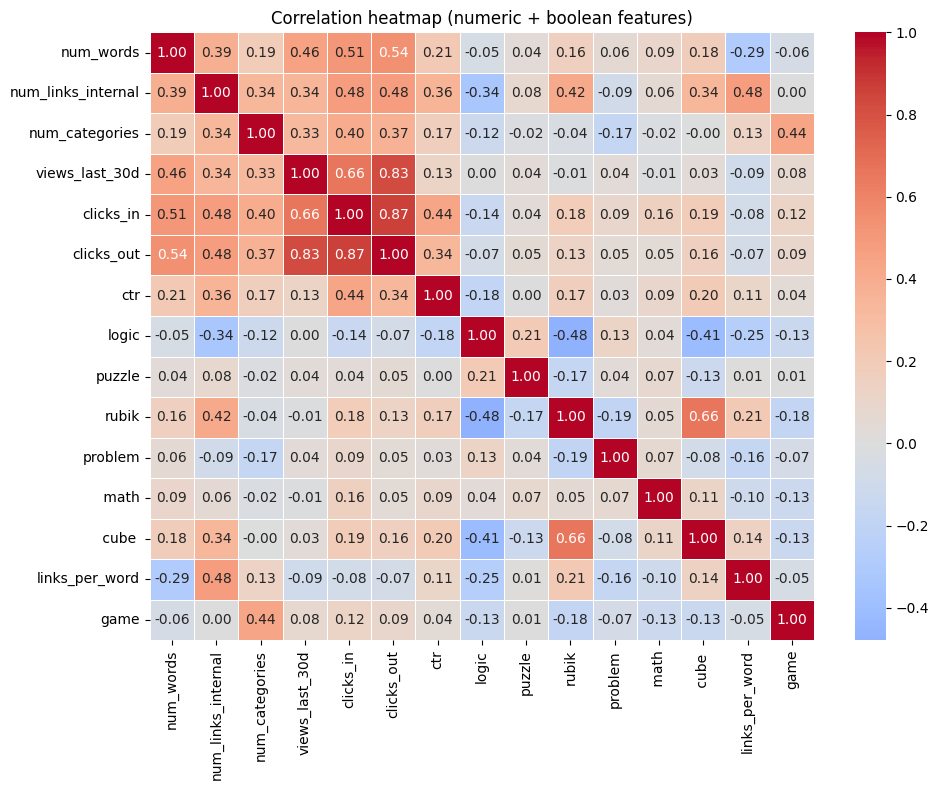

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- wybierz tylko kolumny numeryczne i boolowskie ---
num_bool_cols = df.select_dtypes(include=["number", "bool"]).columns

# --- konwersja bool → int (dla korelacji) ---
df_corr = df[num_bool_cols].copy()
df_corr = df_corr.astype(float)

# --- oblicz korelację ---
corr = df_corr.corr()

# --- rysowanie heatmapy ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Correlation heatmap (numeric + boolean features)")
plt.tight_layout()
plt.show()


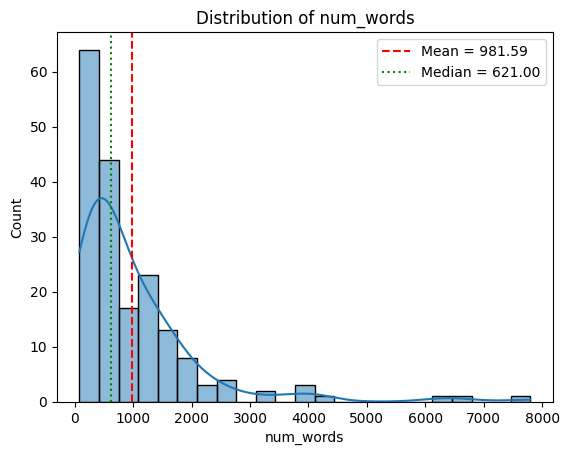

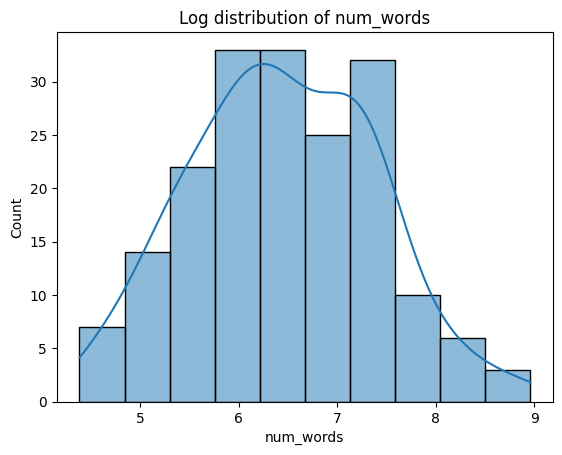

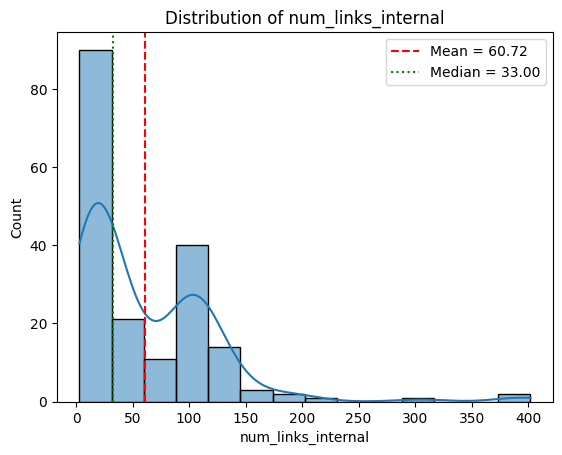

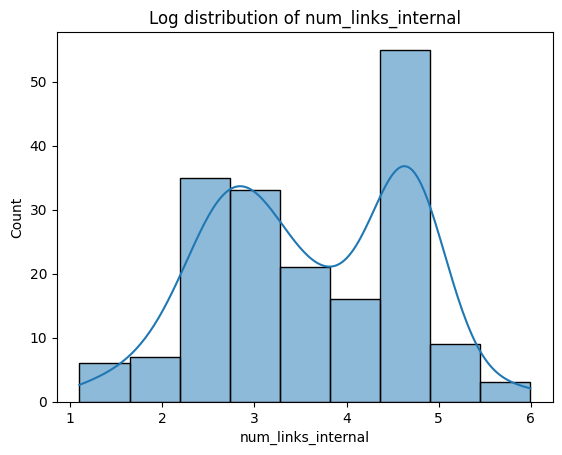

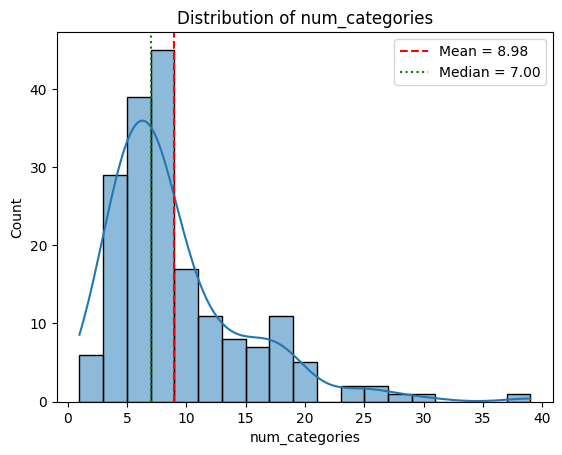

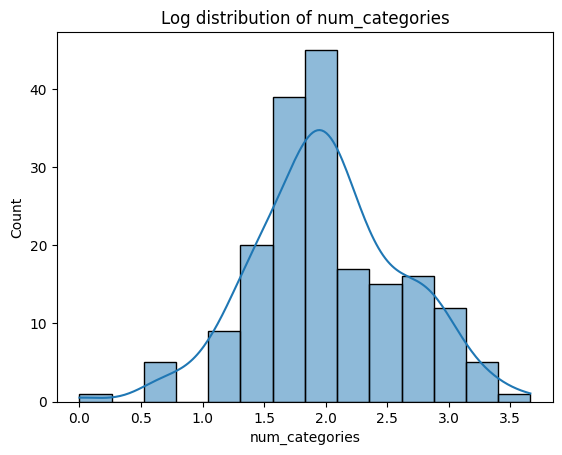

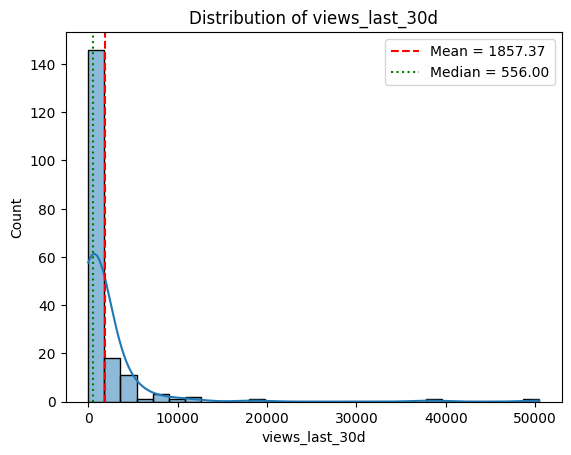

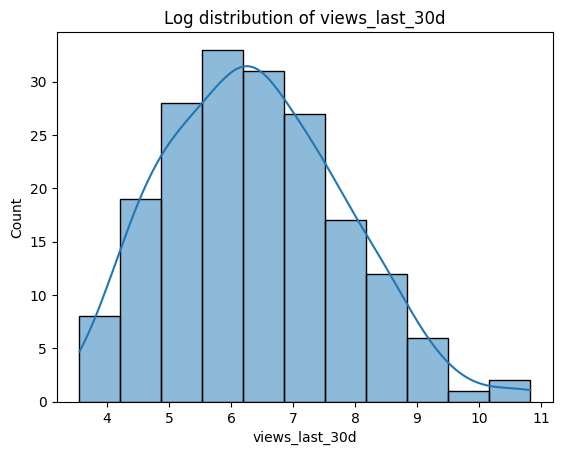

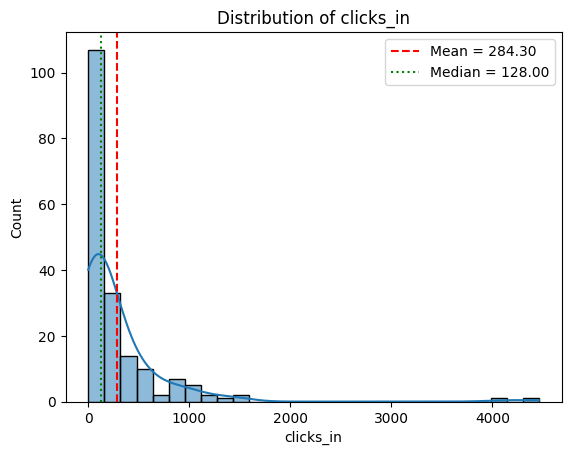

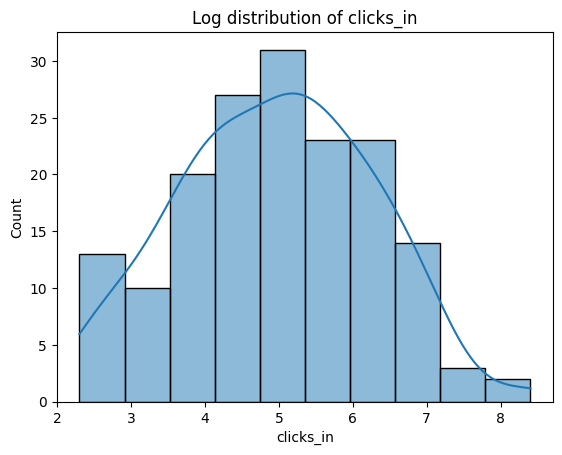

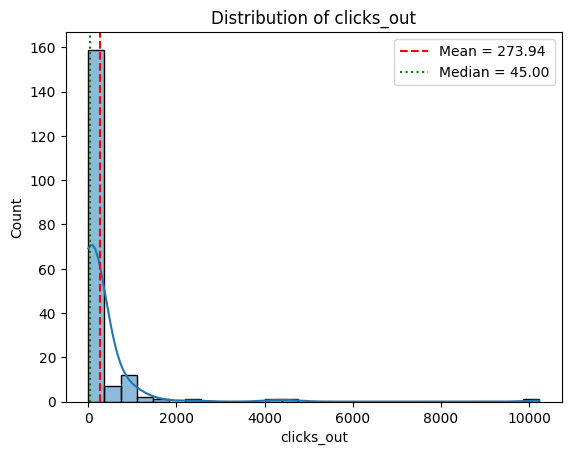

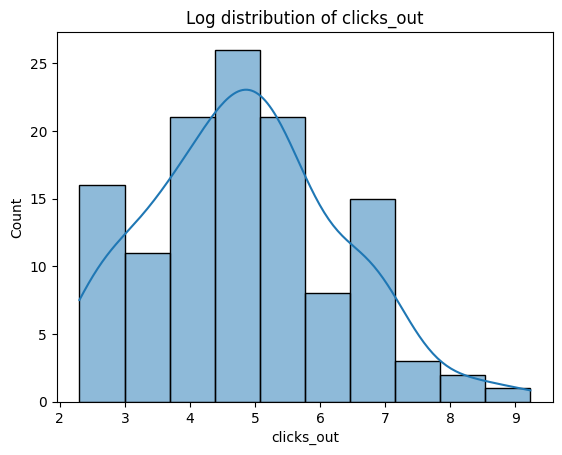

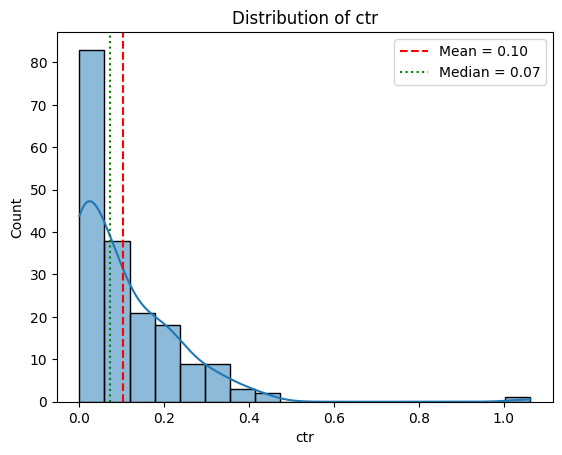

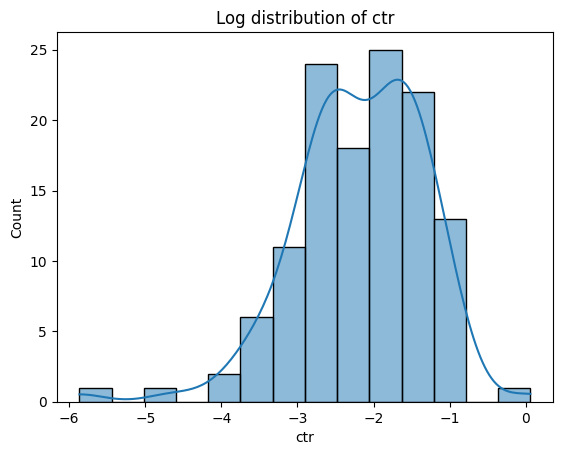

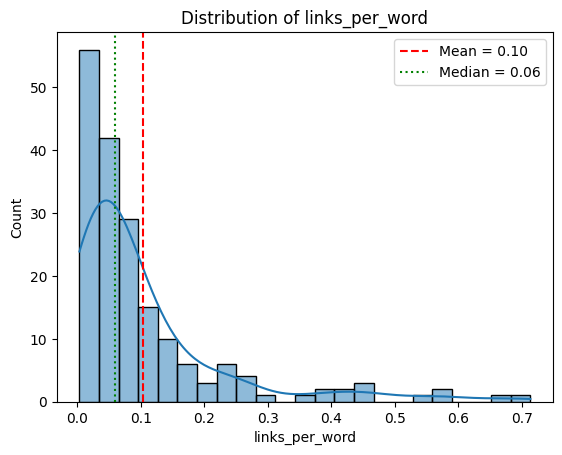

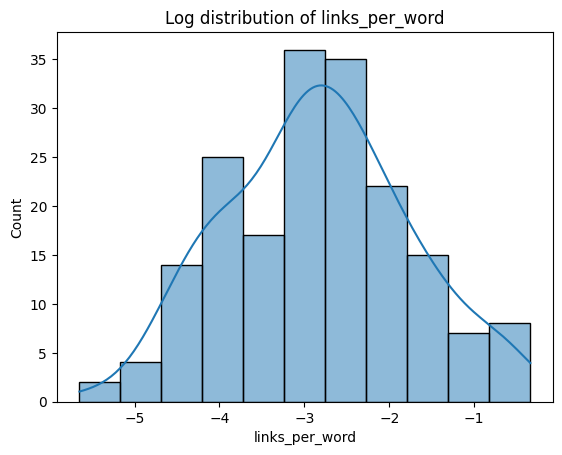

In [37]:
for col in df.select_dtypes(include=["number"]).columns:
    sns.histplot(df[col],kde=True)
    plt.title(f"Distribution of {col}")
    mean_val = df[col].mean()
    median_val = df[col].median()
    
    plt.axvline(mean_val, color="red", linestyle="--", label=f"Mean = {mean_val:.2f}")
    plt.axvline(median_val, color="green", linestyle=":", label=f"Median = {median_val:.2f}")
    plt.legend()
    plt.show()
    
    sns.histplot(np.log(df[df[col]>0][col]),kde=True)
    plt.title(f"Log distribution of {col}")
    plt.show()

In [ ]:
df["ctr"]

In [ ]:
pytrends = TrendReq(hl='en-US', tz=360)
articles = df_articles_summary['title'].tolist()

trends_data = {}
batch_size = 1
for i in range(0, len(articles), batch_size):
    batch = articles[i:i+batch_size]
    try:
        pytrends.build_payload(batch, timeframe='2024-09-01 2024-09-30', geo='')
        df_trends = pytrends.interest_over_time()
        if not df_trends.empty:
            for col in batch:
                trends_data[col] = df_trends[col].mean()
        else:
            for col in batch:
                trends_data[col] = 0
        time.sleep(random.uniform(1.5, 3.0))
    except Exception as e:
        print(f"Błąd dla batch {batch}: {e}")
        for col in batch:
            trends_data[col] = 0

trends_df = pd.DataFrame(list(trends_data.items()), columns=['title', 'Avg_Popularity'])
